In [ ]:
# how much n% correct prediction is robust enough to earn money 
# suppose that: n% prediction is correct, 1-n% prediction is incorrect
# while the order is random, to analyze the robustness
# for example, 4-day stocks, 0 means wrong prediction, 1 means right prediction
  # [0, 1, 0, 1], [1, 1, 0, 0] are 2 types of prediction / 2 permutations
    # with the same percentatge correct prediction: 50%, 
    # while they may have different returns
# this function is to generate huge amount of permutations to simulate big-data analysis
  # to figure out the how much percentage to earn money 
  # for certain percentage correct prediction

In [277]:
#!pip install yfinance
import yfinance as yf # https://pypi.org/project/yfinance/
import math
### the meaning of prediction about stock market
from numpy.core.numeric import ones_like
import random
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [437]:
# get data by ticker-name, start-time & end-time
def get_df_data(ticker_name="AAPL", start_time="2022-01-01", end_time="2022-10-09"):
  df_data = yf.download(tickers=ticker_name, start=start_time, end=end_time) 
  #df_data.head()
  return df_data

# 
def get_df_data_update(ticker_name="AAPL", start_time="2022-01-01", end_time="2022-10-09", interval_len='1d'):
  df_data = yf.download(tickers=ticker_name, start=start_time, end=end_time, interval=interval_len) 
  #df_data.head()
  return df_data

# calculate the daily return by (current_index - previous_index) / previous_index
def calculate_daily_return(df_data, OHLC_index="Close"):
  name1 = OHLC_index+"_previous"
  df_data[name1] = df_data[OHLC_index].shift(1)
  name2 = OHLC_index+"_delta"
  df_data[name2] = df_data[OHLC_index] - df_data[name1]
  name3 = OHLC_index+"_return"
  df_data[name3] = df_data[name2] / df_data[name1]
  del df_data[name1]
  del df_data[name2]
  new_feature = name3
  return df_data #, new_feature

# get the market movement (yesterday -> today) based on daily return, 
  # 1 means rise and 0 fall
def get_market_movement(df_data, signal_name="Close_return"):
  df_data["movement"] = df_data[signal_name]>0
  df_data["movement"] = df_data["movement"].astype(int)
  return df_data

# convert the time to be string type: yyyy-mm-dd
def get_ymt_date(df_data):
  df_data["ymd_time"] = df_data.index
  df_data["ymd_time"] = df_data["ymd_time"].astype(str)
  df_data["ymd_time"] = df_data["ymd_time"].str.slice(0,10)
  # month
  df_data["monthNumber"] = df_data["ymd_time"].str.slice(5,7)
  df_data["monthNumber"] = df_data["monthNumber"].astype(int)
  # week
  df_data['ymd_time'] = pd.to_datetime(df_data['ymd_time'], errors ='coerce')
  df_data['weekNumber'] = df_data['ymd_time'].dt.isocalendar().week
  return df_data

# calculate basic-level strategy: buy & hold
def basic_level_strategy(df_data, feature_name="Close_return"):
  daily_return_list = list( df_data[feature_name] )
  base_money = 1.0
  for change in daily_return_list:
    # math.isnan(daily_return_list[0])
    if not math.isnan(change):
      base_money = base_money * (1+change)
  return base_money

# trade under the algorithmic strategy
def algo_trading_strategy(interest_accumulate):
  # calculate the profit according to the above trading position
    # suppose the bid/ask fee is 0.25% (HSBC) every position change
  transact_fee = -0.25 * 0.01
  profit = 1.0
  position = "short" # short means not in the market or exit
  enter_market = False
  for it in interest_accumulate:
    ymd, close, signal = it
    if signal=="long":
      if position != signal:
        profit = profit * (1+transact_fee) # enter market
      profit = profit * (1+close)
      position = signal
    else:
      if position != signal:
        profit = profit * (1+transact_fee) # exit market
      position = signal    
  return profit


# how much n% correct prediction is robust enough to earn money 
# suppose that: n% prediction is correct, 1-n% prediction is incorrect
# while the order is random, to analyze the robustness
# for example, 4-day stocks, 0 means wrong prediction, 1 means right prediction
  # [0, 1, 0, 1], [1, 1, 0, 0] are 2 types of prediction / 2 permutations
    # with the same percentatge correct prediction: 50%, 
    # while they may have different returns
# this function is to generate huge amount of permutations to simulate big-data analysis
  # to figure out the how much percentage to earn money 
  # for certain percentage correct prediction
def generate_permutation(random_seed, list_len, accuracy_ratio):
  ones = int(accuracy_ratio * list_len)
  zeros = list_len - ones
  a_list = []
  for i in range(ones):
    a_list.append(1)
  for i in range(zeros):
    a_list.append(0)
  random.seed(random_seed)
  random.shuffle(a_list)
  return a_list

# use Mont Carlo simulation to generate random samples
  # to approach the probability of truth 
def Mont_Carlo_simulation(tmp_data, random_seed=10, accuracy_ratio=0.6):
  df_data = tmp_data.copy()
  #print("buy_and_hold 1: ", buy_and_hold, "buy_and_hold 2: ", buy_and_hold)
    # generate random permutations,
    # namely, the prediction of movement: rise 1 / fall 0
  list_len = len(df_data)
  predict_list = generate_permutation(random_seed, list_len, accuracy_ratio)
    # get the real movement of the stock
  ymd_time, Close_return = list(df_data["ymd_time"]), list(df_data["Close_return"])
  movement = list(df_data["movement"])
  assert len(ymd_time)==len(predict_list)
    # simulate the algorithmic trading according to prediction about movement
      # the prediction about movement is of certain accuracy
  interest_accumulate = []
  ii = 0
  while ii < list_len:
    ymd = ymd_time[ii]
    close = Close_return[ii] # daily return 
    move = movement[ii] # the movement, that is, 1 for positive daily return, 0 for negative
    predict = predict_list[ii]
    if predict == 1: # predict accurately, 
          # if movement is rise then buy and get the interest, 
          # if movement is fall the do nothing (short) and avoid the loss
      #interest_accumulate.append( (ymd, close, move, 1) )
      if move==1:
        interest_accumulate.append( (ymd, close, "long") )
      else:
        interest_accumulate.append( (ymd, close, "short") )
      #
    else: # predict inaccurately
          # if movement is rise then do nothing (short) and miss the interest, 
          # if movement is fall then buy and get the loss
      #interest_accumulate.append( (ymd, close, move, 0) )
      if move==1:
        interest_accumulate.append( (ymd, close, "short") )
      else:
        interest_accumulate.append( (ymd, close, "long") )
    ii += 1
  return interest_accumulate

# calculate common statistical indicators for list-type data, such as: max, min, avg/mean, median, 10-percentile, 90-percentile
def statistical_indicators(tmp_list):
  tmp_list = sorted(tmp_list)
  L = len(tmp_list)
  mx, mn = max(tmp_list), min(tmp_list)
  avg = sum(tmp_list)/len(tmp_list)
  med = tmp_list[L//2]
  last_10 = tmp_list[ int(L*0.1) ]
  first_10 = tmp_list[ int(L*0.9) ]
  return mx, mn, avg, med, first_10, last_10

# check the prediction meaning, how much accuracy of prediction will be robust enough to make money
def prediction_analysis(tn="9888.HK", st="2022-01-01", et="2022-12-31"):
    predict_accuracy_list = []
    win_ratio_list = []
    basic_level_list = []
    max_predict_list = []
    min_predict_list = []
    avg_predict_list = []
    med_predict_list = []
    f10_predict_list = []
    l10_predict_list = []
    #
    df_data = get_df_data(ticker_name=tn, start_time=st, end_time=et)
    df_data = get_ymt_date(df_data)
    df_data = calculate_daily_return(df_data)
    df_data = get_market_movement(df_data)
    df_data = df_data.dropna()
    #
    offset_profit = 0.10
    set_accuracy = 0.50
    for ii in range(0, 20):
        set_accuracy += 0.01
        win_loss_list = []
        return_list = []
        for rs in range(5000): # 
            # basic level strategy
            buy_and_hold = df_data["Close"][-1]/df_data["Close"][0]
            buy_and_hold = basic_level_strategy(df_data)
            # algo_trading_strategy
            interest_accumulate = Mont_Carlo_simulation(df_data, rs, set_accuracy)
            profit = algo_trading_strategy(interest_accumulate)
            #print( buy_and_hold, profit )
            if profit>buy_and_hold+offset_profit:
                win_loss_list.append(1)
            else:
                win_loss_list.append(0)
            return_list.append( profit )
        win, loss = sum(win_loss_list), len(win_loss_list)-sum(win_loss_list)
        mx, mn, avg, med, first_10, last_10 = statistical_indicators(return_list)
        #max_profit, min_profit, avg_profit = round(max(return_list), 2), round(min(return_list), 2), round(sum(return_list)/len(return_list), 2)
        #print(set_year, "\t", round(set_accuracy*100), "% accuracy \t", win, loss, round(win/(win+loss)*100, 2))
        #print("\t", max_profit, min_profit, avg_profit, round(buy_and_hold, 2))
        #
        predict_accuracy_list.append( round(set_accuracy*100) )
        win_ratio_list.append( round(win/(win+loss), 2) )
        basic_level_list.append( round(buy_and_hold, 2) )
        max_predict_list.append( mx )
        min_predict_list.append( mn )
        avg_predict_list.append( avg )
        med_predict_list.append( med )
        f10_predict_list.append( first_10 )
        l10_predict_list.append( last_10 )
        if set_accuracy>=0.65:
            print( buy_and_hold, "\t", round(set_accuracy, 2), mn, last_10 )
    ys = [
      win_ratio_list, basic_level_list,
      max_predict_list, min_predict_list, avg_predict_list,
      med_predict_list, f10_predict_list, l10_predict_list
      ]
    return predict_accuracy_list, ys

# draw lines, those lines share the same x values, but different y values
def draw_lines(x, ys):
    predict_accuracy_list = x
    [
      win_ratio_list, basic_level_list,
      max_predict_list, min_predict_list, avg_predict_list,
      med_predict_list, f10_predict_list, l10_predict_list
      ] = ys
    #
    fig = plt.subplots(figsize =(12, 6))
    plt.plot(predict_accuracy_list, win_ratio_list, label ='win_ratio_list') # , color ='r'
    plt.plot(predict_accuracy_list, basic_level_list, label ='basic_level_list')
    plt.plot(predict_accuracy_list, max_predict_list, label ='max_predict_list')
    plt.plot(predict_accuracy_list, min_predict_list, label ='min_predict_list')
    plt.plot(predict_accuracy_list, avg_predict_list, label ='avg_predict_list')
    plt.plot(predict_accuracy_list, med_predict_list, label ='med_predict_list')
    plt.plot(predict_accuracy_list, f10_predict_list, label ='f10_predict_list')
    plt.plot(predict_accuracy_list, l10_predict_list, label ='l10_predict_list')
    plt.plot(predict_accuracy_list, [1]*len(win_ratio_list), label ='100% groud-level')
    #
    plt.title("the meaning of stock prediction: " + tn)
    plt.xlabel('prediction accuracy')
    plt.ylabel("related analysis")
    #
    plt.legend()
    plt.show()
    return

# 
def binning_frequency(daily_returns, bin_width=0.01):
    tmp_list = sorted(daily_returns)
    mn, mx = tmp_list[0], tmp_list[-1]
    bin_dic = {} # 
    tmp_scale = int( 1/bin_width )
    for v in tmp_list:
        if math.isnan(v):
            continue
        v1 = round(v * tmp_scale)
        if v1 not in bin_dic:
            bin_dic[v1] = 1
        else:
            bin_dic[v1] += 1
    return bin_dic

# 
def week_change(df_data, feature="Close"):
    x, y = [], []
    weeks = set( list(df_data['weekNumber']) )
    for w in list(weeks)[:]:
        tmp_df = df_data[ df_data['weekNumber']==w ]
        tmp_list = tmp_df[feature]
        w_start, w_end = tmp_list[0], tmp_list[-1]
        change = (w_end - w_start)/w_start * 100
        x.append(w)
        y.append(change)
    return x, y

# 
def month_change(df_data, feature="Close"):
    x, y = [], []
    months = set( list(df_data['monthNumber']) )
    for m in list(months)[:]:
        tmp_df = df_data[ df_data['monthNumber']==m ]
        tmp_list = tmp_df[feature]
        m_start, m_end = tmp_list[0], tmp_list[-1]
        change = (m_end - m_start)/m_start * 100
        x.append(m)
        y.append(change)
        #print(m_start, m_end)
    #print(x, y)
    return x, y

# draw bar chart
def draw_bar(x_axis, y_axis, x_name, y_name, tn, title_name="", xt=None):
    data = {
            x_name: x_axis,
            y_name: y_axis
           }
    df = pd.DataFrame(data, columns=[x_name, y_name])
    # Defining the plot size
    # Defining the values for x-axis, y-axis
    # and from which dataframe the values are to be picked
    fig, ax = plt.subplots(figsize=(20, 6))
    plots = sns.barplot(x=x_name, y=y_name, data=df)
    if xt is not None:
        ax.set_xticks(x_axis)
        ax.set_xticklabels(xt)

    # Iterrating over the bars one-by-one
    for bar in plots.patches:
        # Using Matplotlib's annotate function and
        # passing the coordinates where the annotation shall be done
        plots.annotate(format(bar.get_height(), '.2f'),
                       (bar.get_x() + bar.get_width() / 2,
                        bar.get_height()), ha='center', va='center',
                       size=12, xytext=(0, 5),
                       textcoords='offset points')
    # Setting the title for the graph
    plt.title("Stock: " + tn + " " + title_name)
    # Finally showing the plot
    plt.show()
    return 

# convert dict-type data to be 2 lists (x & y)
    # dict-type has keys & values, keys -> x list, values -> y list
def dic_to_xy(tmp_dic):
    index_list = list( range(12) )
    x_axis, y_axis = [], []
    for it in index_list:
        x_axis.append( it  )
        if it not in tmp_dic:
            y_axis.append(0)
        else:
            y_axis.append(tmp_dic[it])
    return x_axis, y_axis

# draw line chart, x:date, y:close point
def line_date_close(df_data, tn):
    x_axis = list( df_data.index )
    y_axis = list( df_data['Close'] ) # Close_return

    fig = plt.subplots(figsize =(12, 6))
    plt.plot(x_axis, y_axis, label = tn) # , color ='r'

    plt.title("Stock: " + tn)
    plt.xlabel('Time')
    plt.ylabel("Close points")

    plt.legend()
    plt.show()
    return 

# draw the distribution of close return, for example, daily close return
def distribution_close_return(df_data, tn):
    date_list = list(df_data.index)
    start_date, end_date = date_list[0], date_list[-1]
    start_date, end_date = str(start_date)[:10], str(end_date)[:10]
    daily_returns = list(df_data['Close_return'])
    x_axis, y_axis = [], []
    bin_width = 0.005
    bin_dic = binning_frequency(daily_returns, bin_width)
    for k, v in bin_dic.items():
        x_axis.append(k*bin_width * 100)
        y_axis.append(v)
    fig = plt.subplots(figsize =(12, 6))
    #plt.plot(x_axis, y_axis, label = tn) # , color ='r'
    plt.bar(x_axis, y_axis, width = 0.4, label = tn)
    #plt.xticks(x_axis)
    plt.yticks(y_axis)    
    plt.title("Stock: " + tn + ", from " + start_date + " to " + end_date)
    plt.xlabel('daily return %')
    plt.ylabel("frequency / business days")
    plt.legend()
    plt.show()
    return 

# 
def get_dates_from_range(start_date, end_dates):
    start = datetime.datetime.strptime(start_date, "%d-%m-%Y") 
    end = datetime.datetime.strptime(end_dates, "%d-%m-%Y")
    date_generated = [start + datetime.timedelta(days=x) for x in range(0, (end-start).days)]
    date_list = []
    for date in date_generated:
        date_ymd = date
        y, m, d = date_ymd.year, date_ymd.month, date_ymd.day
        ymd = str(y) + "-"
        if m<10:
            ymd = ymd + "0" + str(m)
        else:
            ymd = ymd + str(m)
        ymd = ymd + "-"
        if d<10:
            ymd = ymd + "0" + str(d)
        else:
            ymd = ymd + str(d)
        date_list.append( ymd  )
    return date_list

# convert the time to be string type: yyyy-mm-dd
def get_ymt_date(df_data):
  df_data["ymd_time"] = df_data.index
  df_data["ymd_time"] = df_data["ymd_time"].astype(str)
  df_data["hour_minute"] = df_data["ymd_time"].str.slice(11,16)
  df_data["ymd_time"] = df_data["ymd_time"].str.slice(0,10)
  # month
  df_data["monthNumber"] = df_data["ymd_time"].str.slice(5,7)
  df_data["monthNumber"] = df_data["monthNumber"].astype(int)
  # week
  df_data['ymd_time'] = pd.to_datetime(df_data['ymd_time'], errors ='coerce')
  df_data['weekNumber'] = df_data['ymd_time'].dt.isocalendar().week
  return df_data

# search value from a list, return the index
def search_list(date_str, date_list):
  ii = 0
  while ii<len(date_list):
    if date_str==date_list[ii]:
      return ii
    ii += 1
  return -1

# find the index of max value in a list
def find_index_max(tmp_list):
    ind = 0
    mx = tmp_list[ind]
    i = 0
    while i<len(tmp_list):
        if mx<tmp_list[i]:
            mx = tmp_list[i]
            ind = i
        i += 1
    return ind

# find the index of min value in a list
def find_index_min(tmp_list):
    ind = 0
    mn = tmp_list[ind]
    i = 0
    while i<len(tmp_list):
        if mn>tmp_list[i]:
            mn = tmp_list[i]
            ind = i
        i += 1
    return ind

# count frequency
def add_value_to_dic(v, dic):
  if v not in dic:
    dic[v] = 1
  else:
    dic[v] += 1
  return 

# calculate percentage_for_list
def percentage_for_list(tmp_list):
    s = sum(tmp_list)
    if s<=0:
        return []
    ll = []
    for it in tmp_list:
        ll.append( it/s )
    return ll

# calculate the frequencies for high-point, low-point over different time interval
  # time interval: every 30 minutes
def high_low_frequency(tn, st, et):
  date_list = get_dates_from_range("01-01-"+st[:4], "31-12-"+et[:4])
  st_ind, ed_ind = search_list(st, date_list), search_list(et, date_list)
  print( st_ind, date_list[st_ind] )
  print( ed_ind, date_list[ed_ind] )
  #
  high_dic, low_dic = {}, {}
  for i in range(st_ind, ed_ind): # 
    st, et = date_list[i], date_list[i+1]
    print(st, et)
    # intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # df_data = get_df_data(ticker_name=tn, start_time=st, end_time=et) 
    df_data = get_df_data_update(ticker_name=tn, start_time=st, end_time=et, interval_len="30m")
    if len(df_data) != 12:
        continue
    df_data = get_ymt_date(df_data)
    #
    mx_ind = find_index_max(df_data['High'])
    row = df_data.iloc[mx_ind]
    high_point, hm_time = round(row['High'],2), row['hour_minute']
    add_value_to_dic(mx_ind, high_dic)

    mn_ind = find_index_min(df_data['Low'])
    row = df_data.iloc[mn_ind]
    low_point, lm_time = round(row['Low'],2), row['hour_minute']
    add_value_to_dic(mn_ind, low_dic)
  
  return high_dic, low_dic

# calculate the daily return by (close_index - open_index) / open_index
def calculate_daily_return_update(df_data):
    df_data['Close_return'] = (df_data['Close'] - df_data['Open']) / df_data['Open']
    return df_data #, new_feature


def get_stock_info(tn, st, et):
    df_data1 = get_df_data(ticker_name=tn, start_time=st, end_time=et)
    df_data1 = calculate_daily_return(df_data1)
    #df_data1 = calculate_daily_return_update(df_data1)
    df_data1 = get_market_movement(df_data1)
    df_data1 = get_ymt_date(df_data1)
    #
    df_data1["ymd_time"] = df_data1.index
    df_data1["ymd_time"] = df_data1["ymd_time"].astype(str)
    df_data1["ymd_time"] = df_data1["ymd_time"].str.slice(0,10)
    return df_data1


def rise_fall_basic(movement1, movement2, verbose=False):
    assert len(movement1) == len(movement2)
    rise_rise, rise_fall, fall_rise, fall_fall = 0, 0, 0, 0
    for i in range(len(movement1)):
        m1, m2 = movement1[i], movement2[i]
        if m1 == 1 and m2 == 1:
            rise_rise += 1
        elif m1 == 1 and m2 == 0:
            rise_fall += 1
        elif m1 == 0 and m2 == 1:
            fall_rise += 1
        elif m1 == 0 and m2 == 0:
            fall_fall += 1     
    ll = percentage_for_list([rise_rise, rise_fall, fall_rise, fall_fall])
    dic = {}
    dic["rise_rise"] = round(ll[0]*100, 2)
    dic["rise_fall"] = round(ll[1]*100, 2)
    dic["fall_rise"] = round(ll[2]*100, 2)
    dic["fall_fall"] = round(ll[3]*100, 2)
    #
    if verbose:
      r1 = round(rise_rise/(rise_rise+rise_fall)*100, 2)
      r2 = round(rise_fall/(rise_rise+rise_fall)*100, 2)
      msg = "if the first rises, then the second will rise: " + str(r1) + "% & fall: " + str(r2) + "%"
      print(msg)
      r1 = round(fall_rise/(fall_rise+fall_fall)*100, 2)
      r2 = round(fall_fall/(fall_rise+fall_fall)*100, 2)
      msg = "if the first falls, then the second will rise: " + str(r1) + "% & fall: " + str(r2) + "%"
      print(msg)
    return dic

def same_market_stocks(df_data1, df_data2):
    movement1 = list(df_data1['movement'])
    movement2 = list(df_data2['movement'])
    return movement1, movement2


def previous_date(current, days_num=1):
    current = datetime.datetime.strptime(current, "%Y-%m-%d").date() # %H:%M:%S
    previous = current - datetime.timedelta(days=days_num)
    return str(previous)

def next_date(current, days_num=1):
    current = datetime.datetime.strptime(current, "%Y-%m-%d").date() # %H:%M:%S
    next_date = current + datetime.timedelta(days=days_num)
    return str(next_date)

def UST_next_HKT(ust, hkt_list):
    days_num = 1
    while days_num<10:
        hkt = next_date(ust, days_num)
        if hkt in hkt_list:
            return hkt
        days_num += 1
    return ust

def HKT_previous_UST(hkt, ust_list):
    days_num = 1
    while days_num<10:
        ust = previous_date(hkt, days_num)
        if ust in ust_list:
            return ust
        days_num += 1
    return hkt

# suppose the first stock is from US, the second is from HK
def different_market_stocks01(df_data_us, df_data_hk, verbose=False):
    movement_us, movement_hk = [], []
    hkt_list = list(df_data_hk['ymd_time'])
    i = 0
    while i<len(df_data_us): # 
        us_stock_row = df_data_us.iloc[i]
        ust = us_stock_row['ymd_time']
        us_close = us_stock_row['Close_return']
        hkt = UST_next_HKT(ust, hkt_list)
        i += 1
        if ust == hkt:
            if verbose:
              print(ust, "not found corresponding HKT: ", hkt)
            continue
        tmp_df = df_data_hk[df_data_hk['ymd_time']==hkt]
        assert len(tmp_df)==1
        hk_close = tmp_df.iloc[-1]['Close_return']
        #
        if us_close>0:
            movement_us.append(1)
        else:
            movement_us.append(0)
        if hk_close>0:
            movement_hk.append(1)
        else:
            movement_hk.append(0)
    return movement_us, movement_hk

# suppose the first stock is from HK, the second is from US
def different_market_stocks02(df_data_hk, df_data_us, verbose=False):
    movement_hk, movement_us = [], []
    ust_list = list(df_data_us['ymd_time'])
    i = 0
    while i<len(df_data_hk): # 
        hk_stock_row = df_data_hk.iloc[i]
        hkt = hk_stock_row['ymd_time']
        hk_close = hk_stock_row['Close_return']
        ust = HKT_previous_UST(hkt, ust_list)
        i += 1
        if hkt == ust:
            if verbose:
              print(hkt, "not found corresponding UST: ", ust)
            continue
        tmp_df = df_data_us[df_data_us['ymd_time']==ust]
        assert len(tmp_df)==1
        us_close = tmp_df.iloc[-1]['Close_return']
        #print(hkt, hk_close, ust, us_close)
        if hk_close>0:
            movement_hk.append(1)
        else:
            movement_hk.append(0)
        if us_close>0:
            movement_us.append(1)
        else:
            movement_us.append(0)        
    return movement_hk, movement_us

[*********************100%***********************]  1 of 1 completed
business days:  217
rise vs fall:  97 117


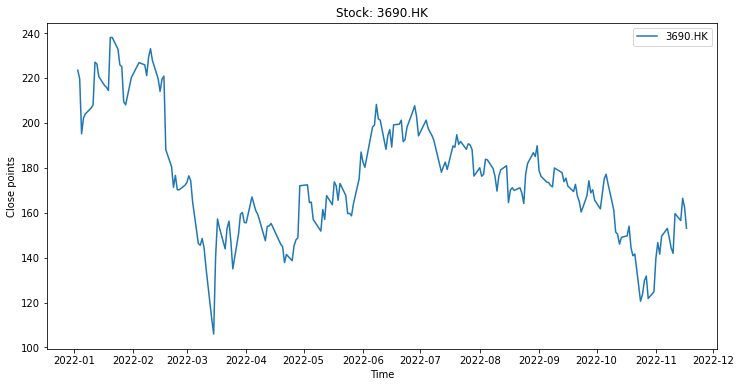

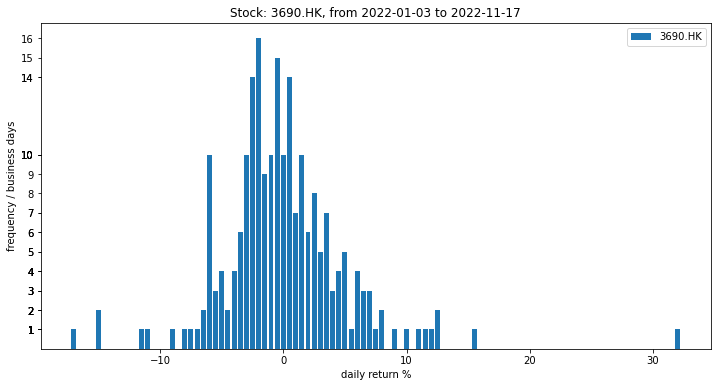

In [417]:
###
# 0005.HK:滙豐控股, 1299.HK:友邦保險, 0700.HK:騰訊控股, 9988.HK:阿⾥巴巴, 3690.HK:美團
hk_tickers = ["3690.HK", "9618.HK", "1024.HK", "9866.HK"]
tn = "3690.HK" # AAPL
st, et = "2022-01-01", "2022-12-31"
df_data = get_df_data(ticker_name=tn, start_time=st, end_time=et)
df_data = calculate_daily_return(df_data)
df_data = get_market_movement(df_data)
# rise-days vs fall-days
pos_df = df_data[df_data['Close_return']>0]
neg_df = df_data[df_data['Close_return']<0]
print( "business days: ", len(df_data) )
print( "rise vs fall: ", len(pos_df), len(neg_df) )
# draw 2 graphs
line_date_close(df_data, tn)
distribution_close_return(df_data, tn)

[*********************100%***********************]  1 of 1 completed


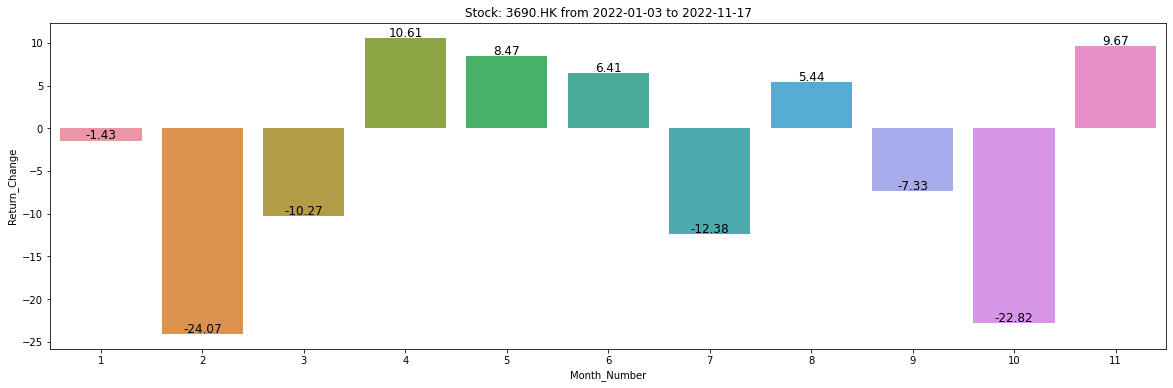

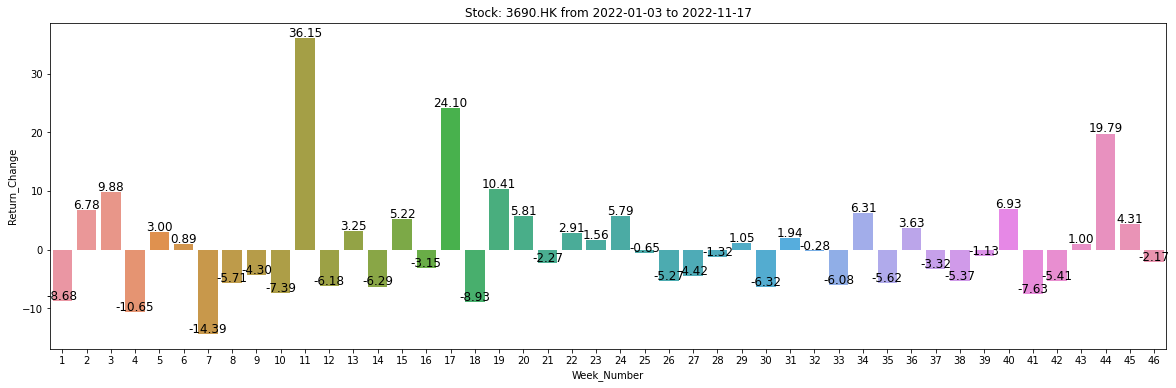

In [418]:
###
# 0005.HK:滙豐控股, 1299.HK:友邦保險, 0700.HK:騰訊控股, 9988.HK:阿⾥巴巴, 3690.HK:美團 # AAPL
hk_tickers = ["3690.HK", "9618.HK", "1024.HK", "9866.HK"]
tn = "3690.HK" 
st, et = "2022-01-01", "2022-12-31"
df_data = get_df_data(ticker_name=tn, start_time=st, end_time=et)
df_data = calculate_daily_return(df_data)
df_data = get_market_movement(df_data)
df_data = get_ymt_date(df_data)

date_list = list(df_data.index)
start_date, end_date = date_list[0], date_list[-1]
start_date, end_date = str(start_date)[:10], str(end_date)[:10]
title_name = "from " + start_date + " to " + end_date
# graph: monthly return 
x_axis, y_axis = month_change(df_data, "Close")
x_name, y_name = "Month_Number", "Return_Change"
draw_bar(x_axis, y_axis, x_name, y_name, tn, title_name)
# graph: weekly return 
x_axis, y_axis = week_change(df_data, "Close")
x_name, y_name = "Week_Number", "Return_Change"
draw_bar(x_axis, y_axis, x_name, y_name, tn, title_name)

[*********************100%***********************]  1 of 1 completed
0.6853178616220408 	 0.65 0.7279000160457676 1.397712297696332
0.6853178616220408 	 0.66 0.8763331244405094 1.501525630654765
0.6853178616220408 	 0.67 0.9053006485910904 1.6140837482575394
0.6853178616220408 	 0.68 0.9421130553807748 1.7437890043731976
0.6853178616220408 	 0.69 1.1954435738347304 1.9389983787236253
0.6853178616220408 	 0.7 1.274141594259853 2.1026883574031725


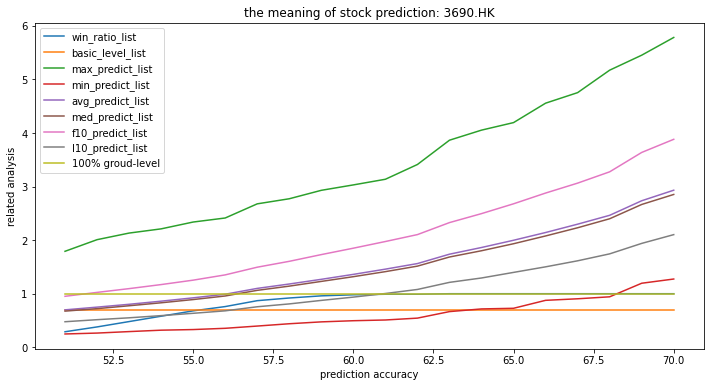

[*********************100%***********************]  1 of 1 completed
0.7633136041249292 	 0.65 0.8686247727726377 1.4721382887748031
0.7633136041249292 	 0.66 0.9670652269553811 1.5844962965673315
0.7633136041249292 	 0.67 1.0289246232767815 1.6946541074659505
0.7633136041249292 	 0.68 1.090515715505183 1.8258443333376175
0.7633136041249292 	 0.69 1.146539902606755 2.0363958083452185
0.7633136041249292 	 0.7 1.2540013644744354 2.1938739832008642


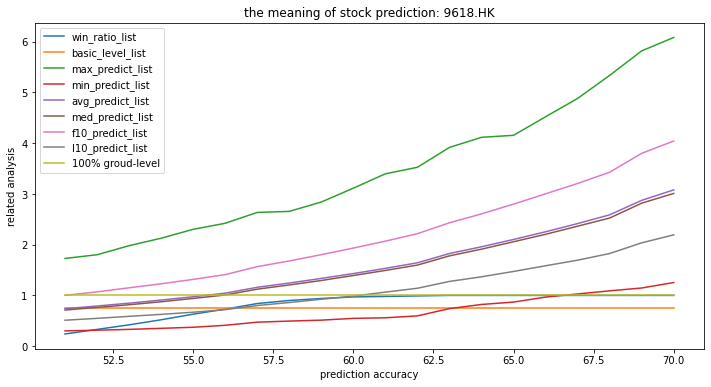

[*********************100%***********************]  1 of 1 completed
0.6689008384254765 	 0.65 0.8181985275519755 1.4120204140938424
0.6689008384254765 	 0.66 0.8514113109075326 1.5278803625482416
0.6689008384254765 	 0.67 0.933900023909169 1.6460217299187456
0.6689008384254765 	 0.68 0.9876306501174217 1.7770188174667836
0.6689008384254765 	 0.69 1.0458298734149967 1.9902318220415716
0.6689008384254765 	 0.7 1.1844658425260295 2.1499923541598864


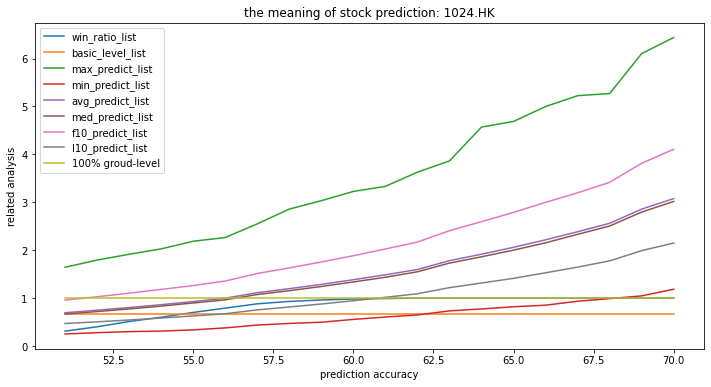

[*********************100%***********************]  1 of 1 completed
0.5125865328937835 	 0.65 0.7715968720942918 1.4051511856636534
0.5125865328937835 	 0.66 0.813073243850553 1.4740739527466609
0.5125865328937835 	 0.67 0.886704335790516 1.6383602844973668
0.5125865328937835 	 0.68 0.9506192461398228 1.8108244812892007
0.5125865328937835 	 0.69 0.9934698780193558 1.904360775278244
0.5125865328937835 	 0.7 1.1499866350938013 2.1017587396026935


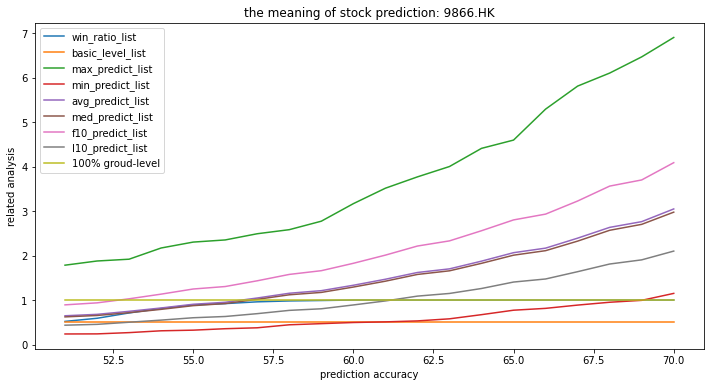

In [419]:
###
# 0005.HK:滙豐控股, 1299.HK:友邦保險, 0700.HK:騰訊控股, 9988.HK:阿⾥巴巴, 3690.HK:美團 # AAPL
hk_tickers = ["9988.HK", "3690.HK", "0700.HK", "9618.HK", "0981.HK", "9999.HK", "1810.HK", "1024.HK", "9888.HK", "2015.HK", "9866.HK"]
hk_tickers = ["3690.HK", "9618.HK", "1024.HK", "9866.HK"]
#tn = "9888.HK" 
for tn in hk_tickers[:]:
    st, et = "2022-01-01", "2022-12-31"
    x, ys = prediction_analysis(tn, st, et)
    draw_lines(x, ys)

In [429]:
### 
# 0005.HK:滙豐控股, 1299.HK:友邦保險, 0700.HK:騰訊控股, 9988.HK:阿⾥巴巴, 3690.HK:美團 # AAPL
hk_tickers = ["3690.HK", "9618.HK", "1024.HK", "9866.HK"]
tn = "3690.HK" 
st, et = "2022-09-16", "2022-11-16"
high_dic, low_dic = high_low_frequency(tn, st, et)

#
index_time = {
    0:'09:30', 1:'10:00', 2:'10:30', 3:'11:00',
    4:'11:30', 5:'13:00', 6:'13:30', 7:'14:00',
    8:'14:30', 9:'15:00', 10:'15:30', 11:'16:00'
}
index_time = [
    '09:30', '10:00', '10:30', '11:00', '11:30', '13:00', '13:30', '14:00','14:30', '15:00', '15:30', '16:00'
]



258 2022-09-16
319 2022-11-16
2022-09-16 2022-09-17
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- 3690.HK: 15m data not available for startTime=1663257600 and endTime=1663344000. The requested range must be within the last 60 days.
2022-09-17 2022-09-18
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- 3690.HK: 15m data not available for startTime=1663344000 and endTime=1663430400. The requested range must be within the last 60 days.
2022-09-18 2022-09-19
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- 3690.HK: 15m data not available for startTime=1663430400 and endTime=1663516800. The requested range must be within the last 60 days.
2022-09-19 2022-09-20
[*********************100%***********************]  1 of 1 completed
2022-09-20 2022-09-21
[*********************100%***********************]  1 of 1 completed
2022-09-21 2022-09-22
[*********************100

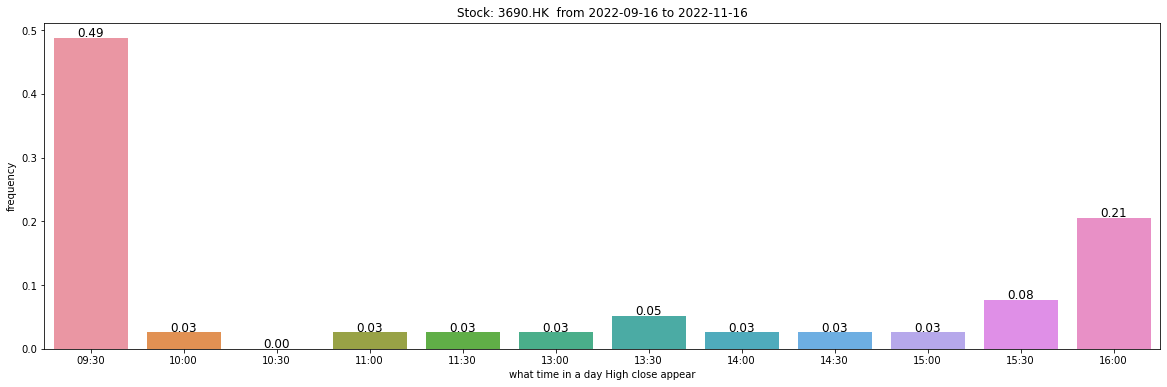

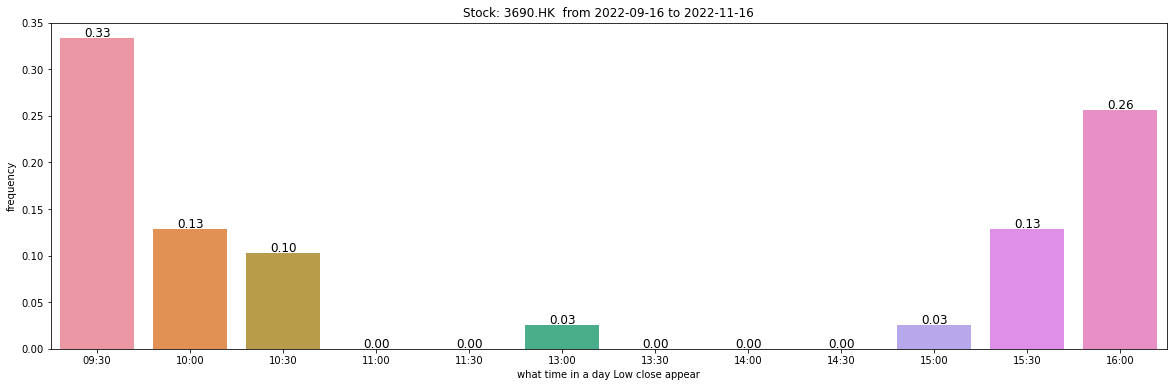

In [432]:
title_name = " from " + st + " to " + et
x_axis, y_axis = dic_to_xy(high_dic) # high_dic, low_dic
y_axis = percentage_for_list(y_axis)
x_name, y_name = 'what time in a day High close appear', 'frequency'
draw_bar(x_axis, y_axis, x_name, y_name, tn, title_name, index_time)

x_axis, y_axis = dic_to_xy(low_dic) # high_dic, low_dic
y_axis = percentage_for_list(y_axis)
x_name, y_name = 'what time in a day Low close appear', 'frequency'
draw_bar(x_axis, y_axis, x_name, y_name, tn, title_name, index_time)


In [438]:
### find the co-relation between 2 stocks
st, et = "2022-01-01", "2022-12-31"

us_stock_ticker = ["AAPL", "GOOGL", "AMZN", "MSFT", "BABA", "PDD", "JD", "NTES", "BIDU", "NIO", "TCOM", "LI", "ZTO", "TME", "XPEV"]
hk_stock_ticker = ["9988.HK", "3690.HK", "0700.HK", "9618.HK", "0981.HK", "9999.HK", "1810.HK", "1024.HK", "9888.HK", "2015.HK", "9866.HK"]

verbose = False
corelation_list1, corelation_list2 = [], []
for tn1 in hk_stock_ticker:
    df_data1 = get_stock_info(tn1, st, et)
    for tn2 in us_stock_ticker:
        df_data2 = get_stock_info(tn2, st, et)
        # US market has influence over HK market
        movement_us, movement_hk = different_market_stocks01( df_data2, df_data1, verbose )
        info = rise_fall_basic(movement_us, movement_hk, verbose)
        corelation = info["rise_rise"] + info["fall_fall"]
        #print(info, corelation)
        corelation_list1.append( (corelation, tn2, tn1) )

        # HK market has influence over US market
        movement_hk, movement_us = different_market_stocks02( df_data1, df_data2, verbose )
        info = rise_fall_basic(movement_hk, movement_us, verbose)
        corelation = info["rise_rise"] + info["fall_fall"]
        #print(info, corelation)
        corelation_list2.append( (corelation, tn1, tn2) )

#
print("US market has influence over HK market: ")
for it in sorted(corelation_list1)[-10:]:
  print("\t", it)

print("HK market has influence over US market: ")
for it in sorted(corelation_list2)[-10:]:
  print("\t", it)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********